<a href="https://colab.research.google.com/github/rkj26/deep-orderbook/blob/rakshit_jha/CoinBase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
!wget -O dataset.7z https://www.dropbox.com/sh/w3qagq2ze9noxon/AACE6f4nkBAJaJEc7Nbf2nhla/coinbase_btc_usd.7z?dl=0

In [1]:
%%capture
!pip install pyunpack
!pip install patool

In [2]:
from pyunpack import Archive

In [3]:
Archive('/content/dataset.7z').extractall("/content")

ValueError: archive file does not exist:/content/dataset.7z

In [1]:
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [2]:
path_ = 'content/coinbase_btc_usd/coinbase/btc_usd/l2_snapshots/100ms/'

In [3]:
# l2_snapshot = pd.read_parquet('/content/coinbase_btc_usd/coinbase/btc_usd/l2_snapshots/100ms/coinbase_btc_usd_l2_book_snapshots_depth50_2019_11_12_0000_0100.parquet')

l2_snapshot = pd.read_parquet('content/coinbase_btc_usd/coinbase/btc_usd/l2_snapshots/100ms/coinbase_btc_usd_l2_book_snapshots_depth50_2019_11_12_0000_0100.parquet')

In [4]:
l2_snapshot.head()

,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,...,aq41,aq42,aq43,aq44,aq45,aq46,aq47,aq48,aq49,aq50
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-11-12 00:00:00.000,8721.53,8720.59,8719.55,8719.50,8719.0,8718.02,8717.87,8717.85,8717.56,8716.06,...,8.200000,2.203,2.600,0.005,2.500,0.896321,0.766000,0.001737,1.820000,0.933419
2019-11-12 00:00:00.100,8721.53,8720.59,8719.56,8719.55,8719.0,8718.02,8717.87,8717.85,8717.56,8716.06,...,8.200000,2.203,2.600,0.005,2.500,0.896321,0.766000,0.001737,1.820000,0.933419
2019-11-12 00:00:00.200,8721.53,8720.59,8719.61,8719.56,8719.0,8718.02,8717.87,8717.85,8716.06,8716.00,...,0.009135,8.200,2.203,2.600,0.005,2.500000,0.896321,0.766000,0.001737,1.820000
2019-11-12 00:00:00.300,8721.53,8720.59,8719.61,8719.56,8719.0,8718.02,8718.00,8717.87,8717.85,8716.60,...,0.009135,8.200,2.203,2.600,0.005,2.500000,0.896321,0.766000,0.001737,1.820000
2019-11-12 00:00:00.400,8721.53,8720.59,8719.61,8719.56,8719.0,8718.99,8718.02,8718.00,8717.87,8717.85,...,0.009135,8.200,2.203,2.600,0.005,2.500000,0.896321,0.766000,0.001737,1.820000


In [5]:
l2_snapshot.isnull().sum()

b1      7452
b2      7452
b3      7452
b4      7452
b5      7452
        ... 
aq46    7452
aq47    7452
aq48    7452
aq49    7452
aq50    7452
Length: 200, dtype: int64

In [6]:
i = 0
for x in os.listdir(path_):
  #Remove the if part to load the full dataset
  if i > 10:
    break
  else:
    if i == 0:
      l2_snapshot = pd.read_parquet('content/coinbase_btc_usd/coinbase/btc_usd/l2_snapshots/100ms/coinbase_btc_usd_l2_book_snapshots_depth50_2019_11_12_0000_0100.parquet')
    else:
      temp = pd.read_parquet(path_+x)
      l2_snapshot_ = l2_snapshot.copy()
      l2_snapshot = pd.concat([l2_snapshot_, temp])
      del temp
      del l2_snapshot_
      gc.collect()
    i = i+1
print('Memory Usage: {} MB'.format(l2_snapshot.memory_usage().sum()/(1024**2)))

Memory Usage: 607.2156143188477 MB


In [7]:
print('Before dropping null values: {}'.format(l2_snapshot.shape))
l2_snapshot.dropna(inplace=True)
print('After dropping null values: {}'.format(l2_snapshot.shape))

Before dropping null values: (395965, 200)
After dropping null values: (253197, 200)


In [8]:
# Function to generate the labels for learning according to the paper
def generate_features_labels(df,ask, bid,k=20, alpha = 10e-5):
  df_ = df.copy()
  df_['mid_price'] = (df_[ask]+df_[bid])/2
  df_['target'] = 1
  index = df_.columns.get_loc('mid_price')
  target_index = df_.columns.get_loc('target')
  shape = df_.shape[0]
  for i in tqdm(range(k,shape-k)):
    m_b = np.mean(df_.iloc[(i-k):i, index].values)
    m_a = np.mean(df_.iloc[i+1:(i+k+1), index].values)

    if (m_b > m_a*(1+alpha)):
      df_.iloc[i,target_index] = 2
    if (m_b < m_a*(1-alpha)):
      df_.iloc[i,target_index] = 0

  y = df_.iloc[k:shape-k, target_index].values
  X = df.iloc[k:shape-k,:].values
  #Free up memory by deleting not required dataframes.
  del df_
  del df
  gc.collect()
  return X,y

In [9]:
X,y = generate_features_labels(l2_snapshot, ask='a1', bid = 'b1')

100%|██████████| 253157/253157 [00:17<00:00, 14401.81it/s]


In [10]:
#Dimensions for the time series
T = 100
D = 200
N = len(X) - T

In [11]:
trainPart = int(len(X)*0.7)  #(70% Data for training and 30% for testing)

#Normalising the whole dataset

scaler = StandardScaler()
scaler.fit(X[:trainPart + T - 1])
X = scaler.transform(X)

In [12]:
#Create the template structure of training set
X_train = np.zeros((trainPart, T, D))
y_train = np.zeros(trainPart)

#Preparing the time series data using timestep of 100 and no of features = 200
for t in range(trainPart):
  X_train[t, :, :] = X[t:t+T]
  y_train[t] = y[t+T] 

# Reducing X_train datasize memory usage
print('X_train - Before: {} GB'.format(X_train.nbytes/1024**3))
X_train = X_train.astype('float16')
print('X_train - After: {} GB'.format(X_train.nbytes/1024**3))

# Reducing Y_train datasize memory usage
print('y_train - before: {} MB'.format(y_train.nbytes/1024**2))
y_train = y_train.astype('int')
print('y_train - After: {} MB'.format(y_train.nbytes/1024**2))

X_train - Before: 26.406198740005493 GB
X_train - After: 6.601549685001373 GB
y_train - before: 1.3519973754882812 MB
y_train - After: 1.3519973754882812 MB


In [13]:
#Create the template structure of test set
X_test = np.zeros((N - trainPart, T, D))
y_test = np.zeros(N - trainPart)

#Preparing the time series data using timestep of 100 and no of features = 200
for k in range(N - trainPart):
  t = k + trainPart
  X_test[k, :, :] = X[t:t+T]
  y_test[k] = y[t+T]

# Reducing X_test datasize memory usage
print('X_test - Before {} GB'.format(X_test.nbytes/1024**3))
X_test = X_test.astype('float16')
print('X_test - After {} GB'.format(X_test.nbytes/1024**3))

# Reducing Y_test datasize memory usage
print('y_test - Before: {} MB'.format(y_test.nbytes/1024**2))
y_test = y_test.astype('int')
print('y_test - After: {} MB'.format(y_test.nbytes/1024**2))

X_test - Before 11.30223274230957 GB
X_test - After 2.8255581855773926 GB
y_test - Before: 0.57867431640625 MB
y_test - After: 0.57867431640625 MB


In [14]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0-beta1

# try:
#   %tensorflow_version 2.x  # Colab only.
# except Exception:
#   pass

import tensorflow as tf
print(tf.__version__)

2.16.2


In [15]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled")
    except RuntimeError as e:
        print(e)

GPU memory growth enabled


In [16]:
from tensorflow.keras.layers import Input, Conv1D, Conv2D, Flatten, MaxPooling1D, MaxPooling2D, Dense, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

In [17]:
#Converting X_train and X_test for 2D Convolution
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

In [20]:
#Model architecture is as from the report
#T = 100 from the above step for timesteps and D = 200 (no. of features) 
i = Input(shape=X_train[0].shape)
print(i)
x = Conv2D(16, (4,D), activation=LeakyReLU(negative_slope=0.01))(i)
print(x.shape)
x = tf.keras.layers.Reshape(target_shape=(T-3,16))(x)
print(x.shape)
x = Conv1D(16, 4, activation=LeakyReLU(negative_slope=0.01))(x)
x = MaxPooling1D(2)(x)
x = Conv1D(32, 3, activation=LeakyReLU(negative_slope=0.01))(x)
x = Conv1D(32, 3, activation=LeakyReLU(negative_slope=0.01))(x)
x = MaxPooling1D(2)(x)
x = Flatten()(x)
x = Dense(32, activation=LeakyReLU(negative_slope=0.01))(x)
x = Dense(3, activation='softmax')(x)

model = Model(i,x)

<KerasTensor shape=(None, 100, 200, 1), dtype=float32, sparse=False, name=keras_tensor>
(None, 97, 1, 16)
(None, 97, 16)


In [21]:
#Printing Model Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 200, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 97, 1, 16)      │        12,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 97, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 94, 16)         │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 47, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 45, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 43, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 21, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 672)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        21,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,163 (156.89 KB)

 Trainable params: 40,163 (156.89 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
#Accuracy is not a great metrics

In [24]:
from sklearn.utils.class_weight import compute_class_weight
def compute_class_weights(y):
    classes = np.unique(y)
    class_weight = compute_class_weight(class_weight="balanced", classes=classes, y=y)
    class_weights = dict(zip(classes, class_weight))
    return class_weights

In [25]:
#computing class weights according to the percentage in training dataset
class_weights = compute_class_weights(y_train)

In [ ]:
# with tf.device('/GPU:0'):
#     X_train = tf.convert_to_tensor(X_train)
#     y_train = tf.convert_to_tensor(y_train)
#     X_test = tf.convert_to_tensor(X_test)
#     y_test = tf.convert_to_tensor(y_test)

In [27]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
EPOCHS = 50
BATCH_SIZE = 16
r = model.fit(
  X_train, y_train,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_data=(X_test, y_test),
  class_weight = class_weights
)

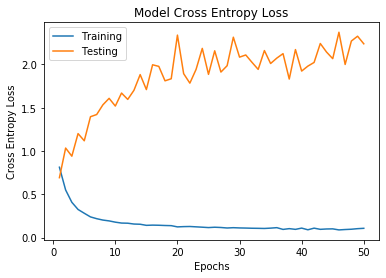

In [0]:
sns.lineplot(x=range(1,EPOCHS+1),y=r.history['loss'])
sns.lineplot(x=range(1,EPOCHS+1),y=r.history['val_loss'])
plt.title('Model Cross Entropy Loss')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'Testing'], loc='upper left')

In [0]:
# Model is clearly overfitting as the training loss is decreasing but the testing loss is just increasing. The confusion matrix below gives better information

In [0]:
y_pred = model.predict(X_test).argmax(axis=1)

In [0]:
 model.predict(X_test)

array([[9.9944943e-01, 5.5062218e-04, 5.9082446e-26],
       [9.5253259e-01, 4.7467332e-02, 1.0671785e-19],
       [9.6852845e-01, 3.1471580e-02, 6.8123664e-17],
       ...,
       [7.4375956e-03, 9.9205458e-01, 5.0786865e-04],
       [1.0000000e+00, 4.6534499e-08, 0.0000000e+00],
       [5.2140851e-02, 9.4785911e-01, 2.2283022e-12]], dtype=float32)

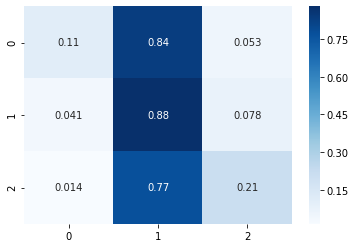

In [0]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
    
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
ax=sns.heatmap(cm, annot=True, xticklabels=[0,1,2], yticklabels=[0,1,2], cmap='Blues')
ax.set_ylim(3.0, 0)
plt.show()

In [0]:
#Print the classification report
print(classification_report(y_true= y_test, y_pred = y_pred))

              precision    recall  f1-score   support

           0       0.08      0.11      0.09      1865
           1       0.94      0.88      0.91     60324
           2       0.08      0.21      0.12      2096

    accuracy                           0.84     64285
   macro avg       0.37      0.40      0.37     64285
weighted avg       0.89      0.84      0.86     64285
